In [1]:
import os
# running from Root directory
os.chdir("..")

In [22]:
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties
from networks.loaders.network_loader import NetworkLoader
from utils.types import NetworkInputType, NetworkLoaderArgs
from networks.network import Network
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

simple_input_args = NetworkLoaderArgs(
    synapse_threshold=5,
    filter_polarity=['+', '-'],
    filter_prim_nt=['GABA', 'Glu', 'ACh', 0],
    filter_syn_type='chem',
    filter_sex_type='herm',
    filter_nerve_ring_neurons=True
)
loader = NetworkLoader(simple_input_args)

network = loader.load_network_file(file_path="networks/data/polarity_2020/s1_data.xlsx",
                                   input_type=NetworkInputType.polarity_xlsx)


# network = loader.load_network_file(file_path="networks/data/Cook_2019/SI 2 Synapse adjacency matrices.xlsx",
#                                     input_type=NetworkInputType.worm_wiring_xlsx)


#network = loader.load_network_file(file_path="networks/data/Cook_2019/SI 5 Connectome adjacency matrices, corrected July 2020.xlsx",
#                                    input_type=NetworkInputType.worm_wiring_xlsx)



Network file name: s1_data.xlsx
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['GABA', 'Glu', 'ACh', 0]
Polarity ratios (before filtering): Counter({'+': 0.757420091324201, '-': 0.2425799086757991})

Network properties:
	Neurons in the network: 283
	Participating Neurons (in the graph): 172

	Participating Nodes are neurons with at least: 5 synapses
	Synapses in the network: 7693
	Synapses in the graph: 6415
	Gaps in the network: 0
	Gaps in the graph: 0
	Nodes: 161
	Edges: 423
	Average clustering coefficient: 0.068
	Average shortest path (undirected): 2.252
	Density: 0.016
	Polarity ratios: Counter({'+': 0.6855791962174941, '-': 0.3144208037825059})
	Degree: Mean: 5.255 Std: 4.68 Median: 4.0 Max: 25 (node: RIAL)
	In-Degree: Mean: 2.627 Std: 4.084 Median: 1.0 Max: 22 (node: AVBL)
	Out-Degree: Mean: 2.627 Std: 2.519 Median: 2.0 Max: 13 (node: RIML)


In [3]:
def basic_plot(data: Any, title: str, xlabel: str, ylabel: str, plot_func: Any, log_scale=False):
    plt.figure()

    if log_scale:
        plt.yscale("log")
        plt.xscale("log")

    plot_func(*data)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [4]:
def plot_rich_club_coefficient(network: Network):
    un_dir_graph = nx.Graph(network.graph)
    un_dir_graph.remove_edges_from(nx.selfloop_edges(un_dir_graph))
    rc = nx.rich_club_coefficient(un_dir_graph, normalized=False, seed=42)
    data = list(rc.keys()), list(rc.values())
    basic_plot(data=data,
               title='Rich Club Coefficient',
               xlabel='Degree (k)',
               ylabel='Rich Club Coefficient',
               plot_func=plt.scatter)


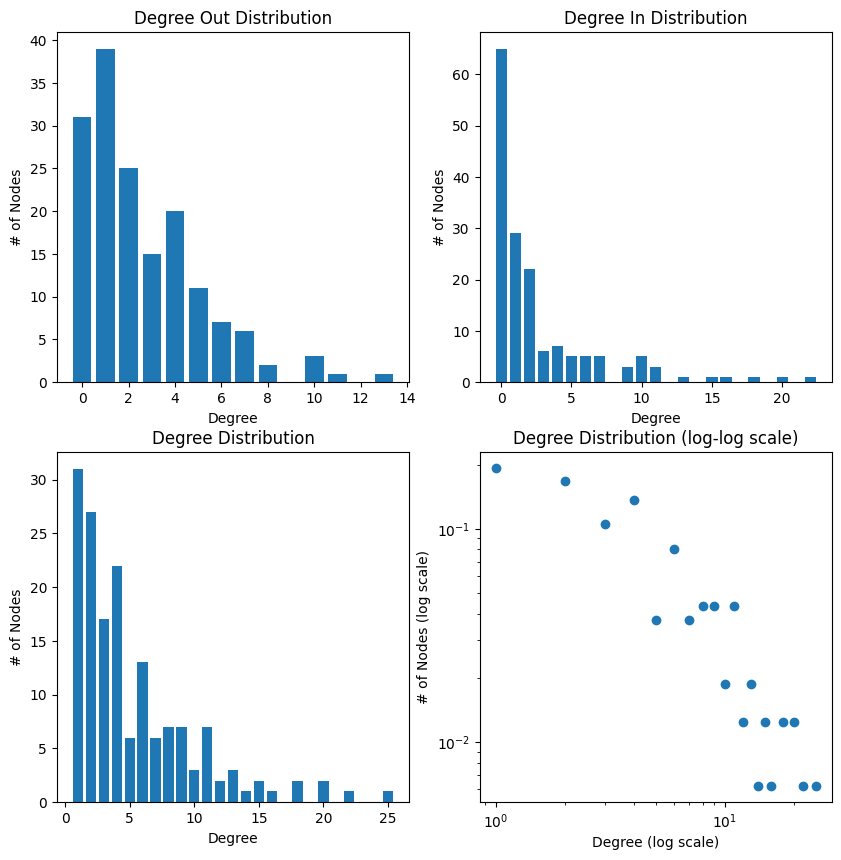

In [23]:
def _set_bar_subplot(ax, data, title, xlabel, ylabel):
    ax.bar(*data)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_degree_dist(network: Network):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    degree_sequence = sorted((d for n, d in network.graph.out_degree), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[0,0], data, 'Degree Out Distribution', 'Degree', '# of Nodes')

    degree_sequence = sorted((d for n, d in network.graph.in_degree), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[0,1], data, 'Degree In Distribution', 'Degree', '# of Nodes')

    degree_sequence = sorted((d for n, d in network.graph.degree()), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[1,0], data, 'Degree Distribution', 'Degree', '# of Nodes')

    # Log-Log
    y = nx.degree_histogram(network.graph)
    x = np.arange(0, len(y)).tolist()
    n = network.graph.number_of_nodes()

    for i in range(len(y)):
        y[i] = y[i] / n
    
    ax[1,1].plot(x, y, 'o')
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlabel('Degree (log scale)')
    ax[1,1].set_yscale('log')
    ax[1,1].set_ylabel('# of Nodes (log scale)')
    ax[1,1].set_title('Degree Distribution (log-log scale)')


plot_degree_dist(network)

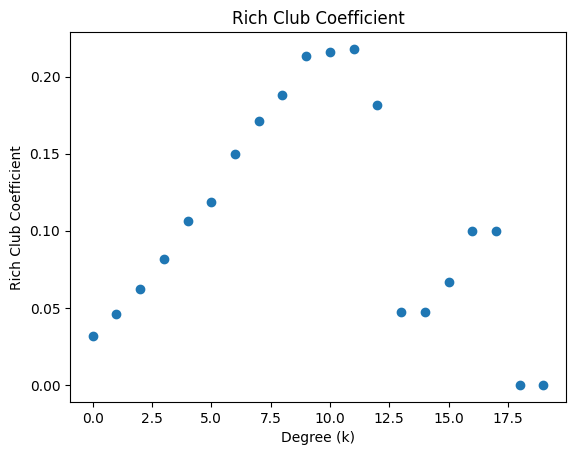

In [24]:
plot_rich_club_coefficient(network)

['ADAL', 'ADAR', 'ADLL', 'ADLR', 'AQR', 'ASHR', 'AVJR', 'DVC', 'FLPL', 'FLPR', 'AVDR']


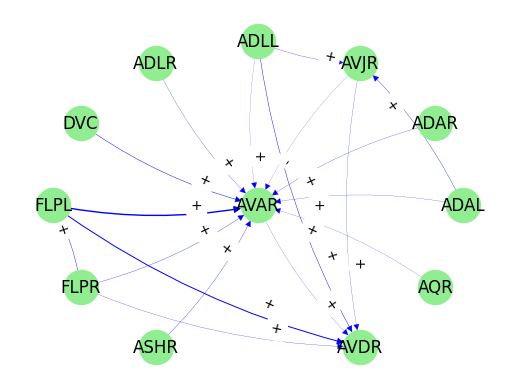

In [27]:
draw_neighbors(network, 'AVAR', 'all', False)

In [28]:
node_properties(network, 'AIAL')

Node AIAL properties:
Degree: 1
Out Degree: 1
In Degree: 0
Clustering coefficient: 0.0


nerve ring

In [17]:
from random_networks.nerve_ring_markov_chain_switching import NerveRingMarkovChainSwitching
nerve_ring = NerveRingMarkovChainSwitching(network, switch_factor=10)

nerve_ring.DISTANCE_TH = 0.1
nerve_ring.init_nerve_ring_allow_list()
nerve_ring_allow = nerve_ring.nerve_ring_allow

In [18]:
ratios = []
for n in nerve_ring_allow:
    if n not in network.neuron_names:
        # print(n)
        continue
    node_idx = network.neuron_names.index(n)
    
    if node_idx not in dict(network.graph.degree):
        print(n)
        continue

    synapses = network.graph.degree[node_idx]
    pot_synapses = len(nerve_ring_allow[n])
    ratio = synapses / pot_synapses
    print(n, synapses, pot_synapses, round(ratio,2))
    ratios.append(ratio)

ADAR 32 60 0.53
ADAL 35 50 0.7
ADEL 42 24 1.75
ADER 36 27 1.33
ADFL 27 13 2.08
ADFR 38 21 1.81
ADLL 30 32 0.94
ADLR 42 33 1.27
AFDL 17 22 0.77
AFDR 13 19 0.68
AIAL
AIAR 28 29 0.97
AIBL 53 49 1.08
AIBR 57 46 1.24
AIML 24 32 0.75
AIMR 28 41 0.68
AINL 20 43 0.47
AINR 21 41 0.51
AIYL 23 33 0.7
AIYR 26 31 0.84
AIZL 38 33 1.15
AIZR 32 33 0.97
ALA 11 50 0.22
ALML 28 16 1.75
ALMR 11 18 0.61
ALNL 12 24 0.5
ALNR 14 23 0.61
AQR 28 38 0.74
ASEL 28 32 0.88
ASER 36 41 0.88
ASGL 9 10 0.9
ASGR 15 12 1.25
ASHL 25 23 1.09
ASHR 36 20 1.8
ASIL 21 30 0.7
ASIR 15 24 0.62
ASJL 11 31 0.35
ASJR 4 32 0.12
ASKL 11 23 0.48
ASKR 16 15 1.07
AUAL 20 26 0.77
AUAR 20 22 0.91
AVAL 61 66 0.92
AVAR 55 60 0.92
AVBL 54 56 0.96
AVBR 49 57 0.86
AVDL 36 72 0.5
AVDR 41 70 0.59
AVEL 49 59 0.83
AVER 52 66 0.79
AVFL 22 64 0.34
AVFR 24 76 0.32
AVHL 35 60 0.58
AVHR 29 60 0.48
AVJL 34 53 0.64
AVJR 38 58 0.66
AVKL 23 57 0.4
AVKR 28 54 0.52
AVL
AVM 18 40 0.45
AWAL 12 22 0.55
AWAR 23 14 1.64
AWBL 21 26 0.81
AWBR 20 21 0.95
AWCL 24 41 0

(array([24., 65., 55., 19.,  4.,  5.,  1.,  0.,  0.,  1.]),
 array([0.09090909, 0.41306818, 0.73522727, 1.05738636, 1.37954545,
        1.70170455, 2.02386364, 2.34602273, 2.66818182, 2.99034091,
        3.3125    ]),
 <BarContainer object of 10 artists>)

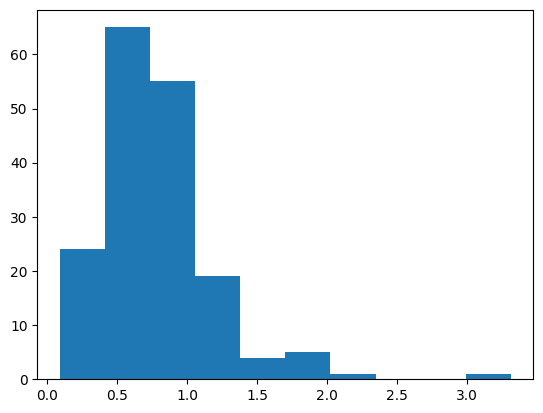

In [19]:
plt.hist(ratios)